# plan

- import wide form score table and the score index key
- use the mask array to convert the score lists to single value scores
- generate bootstrapping replicates - 1000x
  - resample the table with replacement 1000x and store results in a list of dataframes
  - resampled replicates will have the same number or TPs and FPs for each SLiM as the original data
  - convert each replicate into a long form table
  - calculate auPRC scores for each replicate - both combined and for each SLiM
- calculate confidence intervals to use for error bars
- calculate significance of differences between auPRC scores that I refer to use in the manuscript

In [1]:
import local_seqtools.general_utils as tools
import pandas as pd
import numpy as np
import local_conservation_analysis_pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align
import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"
%load_ext autoreload
%autoreload 2

In [2]:
zscores = pd.read_csv('./z_scores_wideform.csv')
score_key = pd.read_csv('./z_scores_score_key.csv')
score_indexes=[i for i in zscores.columns if i in score_key['score_index'].unique()]

from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

zscores['mask_array'] = zscores['mask_array'].str.replace(' ', ',')
zscores['mask_array'] = zscores['mask_array'].apply(literal_eval)

def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

zscores2=zscores.copy()
for i in score_indexes:
    zscores2[i] = zscores2.apply(lambda x: extract_important_scores(x, i), axis=1)
    zscores2[i] = zscores2[i].apply(np.mean)
zscores2 = zscores2[zscores2['ELM_motif_class'] != 'TRAF6']

In [3]:
def get_stratified_sample(dfin, class_col):
    df = dfin.copy()
    tp = df[df[class_col]==True].copy().sample(frac=1, replace=True)
    fp = df[df[class_col]==False].copy().sample(frac=1, replace=True)
    return pd.concat([tp, fp], ignore_index=True)


def make_bootstrap_sample(dfin):
    df = dfin.copy()
    motifs = df['ELM_motif_class'].unique()
    t = [get_stratified_sample(df[df['ELM_motif_class']==i].copy(), 'verified interaction') for i in motifs]
    return pd.concat(t, ignore_index=True)

In [4]:
n_bootstraps = 1000
counter = 0
bootstrap_samples = []
for i in range(n_bootstraps):
    bootstrap_samples.append(make_bootstrap_sample(zscores2))
    counter += 1
    if counter % 100 == 0:
        print(f"Completed {counter} bootstraps")

Completed 100 bootstraps
Completed 200 bootstraps
Completed 300 bootstraps
Completed 400 bootstraps
Completed 500 bootstraps
Completed 600 bootstraps
Completed 700 bootstraps
Completed 800 bootstraps
Completed 900 bootstraps
Completed 1000 bootstraps


# general auPRC - combining all of the SLiMs and treating as a single dataset

In [5]:
from collections import defaultdict
bootstrap_auprc_dict = defaultdict(list)
for i in score_indexes:
    for sample in bootstrap_samples:
        prc_results = tools.df_2_precision_recall_curve(sample, 'verified interaction', score_col=i)
        bootstrap_auprc_dict[i].append(prc_results[3])

In [6]:
confidence_intervals = defaultdict(list)
for k, v in bootstrap_auprc_dict.items():
    confidence_intervals[k] = np.percentile(v, [2.5, 97.5])

(0.0, 1.0)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

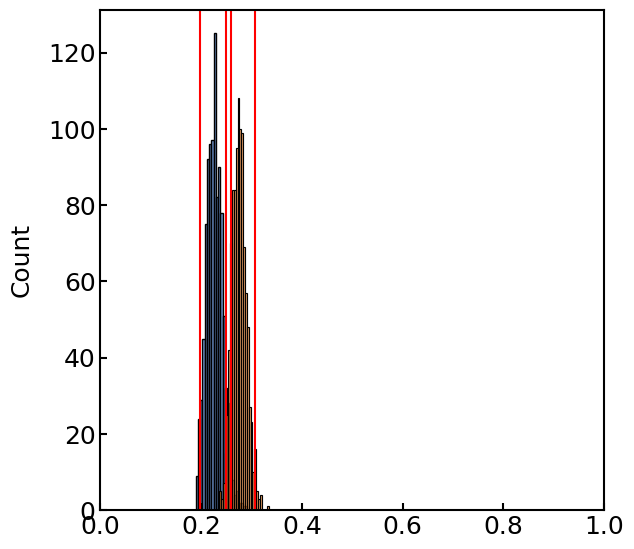

In [7]:
sns.histplot(bootstrap_auprc_dict['0.0'])
plt.axvline(confidence_intervals['0.0'][0], color='red')
plt.axvline(confidence_intervals['0.0'][1], color='red')
sns.histplot(bootstrap_auprc_dict['kibby_hit_zscores'])
plt.axvline(confidence_intervals['kibby_hit_zscores'][0], color='red')
plt.axvline(confidence_intervals['kibby_hit_zscores'][1], color='red')
plt.xlim(0, 1)

put bootstrapping results into a dataframe

In [19]:
general_auprc_df = score_key[score_key['score_index'].isin(score_indexes)].copy()
general_auprc_df['CI'] = general_auprc_df['score_index'].map(confidence_intervals)
# split CI into two columns
general_auprc_df[['CI_lower', 'CI_upper']] = pd.DataFrame(general_auprc_df['CI'].tolist(), index=general_auprc_df.index)
general_auprc_df=general_auprc_df.drop(columns=['CI'])

add real auPRC score to the dataframe

In [20]:
auprc_dict = {}
for i in score_indexes:
    prc_results = tools.df_2_precision_recall_curve(zscores2, 'verified interaction', score_col=i)
    auprc_dict[i] = prc_results[3]
general_auprc_df['auPRC'] = general_auprc_df['score_index'].map(auprc_dict)

In [21]:
temp = general_auprc_df[
    (general_auprc_df['rflank']!='5.0')
].copy()
temp

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing,CI_lower,CI_upper,auPRC
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2490,0.197235,0.259760,0.224899
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2644,0.201798,0.264922,0.228133
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2474,0.180208,0.239807,0.206491
9,9.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2652,0.239420,0.305600,0.269130
24,24.0,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2822,0.272001,0.354490,0.308802
29,29.0,Pairwise,Metazoa,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.324578,0.429871,0.375234
33,33.0,Pairwise embedding,Tetrapoda,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2652,0.262019,0.337121,0.294623
37,37.0,Pairwise embedding,Vertebrata,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2822,0.280943,0.362428,0.318903
41,41.0,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.320942,0.416532,0.365350
42,kibby_hit_zscores,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,0.249293,0.306322,0.273862


/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

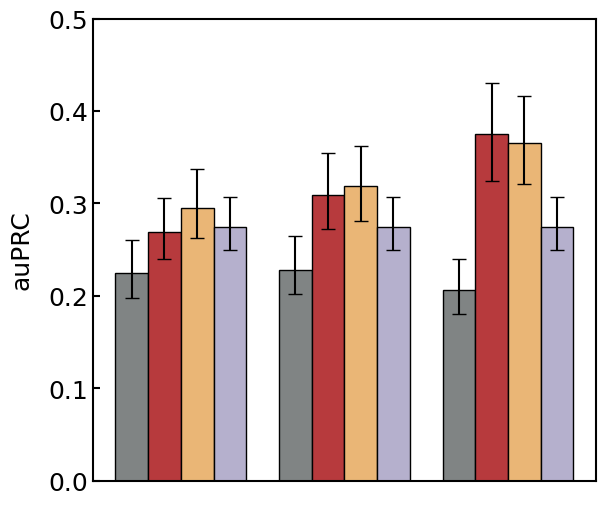

In [22]:
fig, ax = plt.subplots(figsize=(6.5, 6))
sns.barplot(
    data=temp, 
    x='level', 
    y='auPRC', 
    hue='score_key', 
    hue_order=[
        'aln_property_entropy',
        'pairk_aln_lf0_rf0_edssmat50',
        'pairk_aln_embedding_lf0_rf0',
        'kibby',
    ],
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'pairk_aln_lf0_rf0_edssmat50': '#cc2529', 'pairk_aln_embedding_lf0_rf0':'#fdb863'},
    ax=ax,
    legend=False,
)
# add confidence intervals to the plot as error bars
for i, bar in enumerate(ax.patches):
    ci = temp.iloc[i,:]
    ax.errorbar(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height(),
        # yerr=[[bar.get_height()-ci['CI_lower']], [ci['CI_upper']-bar.get_height()]],
        yerr=[[bar.get_height()-ci['CI_lower']], [ci['CI_upper']-bar.get_height()]],
        color='black',
        capsize=5,
    )
ax.set_ylim(0, 0.5)
ax.set_xlabel('')
# remove the xticks
ax.set_xticks([])
plt.savefig('./figure4/auPRC_barplot_general-rbm_f.png', bbox_inches='tight', dpi=400)
# bar_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

It seems like the `ax.patches` are in the order of the original dataframe, so I can use the index to get the correct error bar values. See the test below.

In [23]:
for i, bar in enumerate(ax.patches):
    tempi = temp.iloc[i,:]
    print(i, bar.get_height(), tempi['auPRC'], tempi['CI_lower'], tempi['CI_upper'])
    assert bar.get_height() == tempi['auPRC']

0 0.2248994301515376 0.2248994301515376 0.19723464161263882 0.2597598522556752
1 0.22813315559484101 0.22813315559484101 0.20179812940366285 0.2649218324030407
2 0.20649090958301441 0.20649090958301441 0.18020787376369568 0.23980744205656218
3 0.2691299488720224 0.2691299488720224 0.2394195026913573 0.30559983582426137
4 0.30880205272152506 0.30880205272152506 0.27200114024707167 0.35448973386779603
5 0.3752342229496384 0.3752342229496384 0.3245783357376493 0.4298710068919841
6 0.29462324756602937 0.29462324756602937 0.26201861306809354 0.3371206668531451
7 0.31890305168208954 0.31890305168208954 0.2809429262202697 0.36242819281828537
8 0.3653504719085831 0.3653504719085831 0.32094157337868967 0.41653193517579684
9 0.2738615685559513 0.2738615685559513 0.24929326734251414 0.3063217680576839
10 0.2738615685559513 0.2738615685559513 0.24929326734251414 0.3063217680576839
11 0.2738615685559513 0.2738615685559513 0.24929326734251414 0.3063217680576839


# per SLiM auPRC scores and bootstraps

real auPRC scores

In [24]:
from collections import defaultdict
auprc_slim_dict = defaultdict(list)
for s in zscores2['ELM_motif_class'].unique():
    temp = zscores2[zscores2['ELM_motif_class']==s].copy()
    for i in score_indexes:
        prc_results = tools.df_2_precision_recall_curve(temp, 'verified interaction', score_col=i)
        auprc_slim_dict['score_index'].append(i)
        auprc_slim_dict['ELM_motif_class'].append(s)
        auprc_slim_dict['auPRC'].append(prc_results[3])
auprc_slim_df = pd.DataFrame(auprc_slim_dict)
auprc_slim_df = pd.merge(auprc_slim_df, score_key, on='score_index', how='left')

In [25]:
auprc_slim_df[auprc_slim_df.duplicated(subset=['score_index', 'ELM_motif_class'])]

,score_index,ELM_motif_class,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
16,kibby_hit_zscores,LIG_AP2alpha_2,0.253435,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
17,kibby_hit_zscores,LIG_AP2alpha_2,0.253435,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
34,kibby_hit_zscores,LIG_EH_1,0.311213,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
35,kibby_hit_zscores,LIG_EH_1,0.311213,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
52,kibby_hit_zscores,LIG_SH2_GRB2like,0.234968,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
53,kibby_hit_zscores,LIG_SH2_GRB2like,0.234968,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
70,kibby_hit_zscores,LIG_SH3_CIN85_PxpxPR_1,0.291997,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
71,kibby_hit_zscores,LIG_SH3_CIN85_PxpxPR_1,0.291997,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
88,kibby_hit_zscores,DOC_WW_Pin1_4,0.271185,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
89,kibby_hit_zscores,DOC_WW_Pin1_4,0.271185,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby


Bootstrap auprc and confidence intervals

In [26]:
bootstrap_slim_dict = defaultdict(list)
for slim in zscores2['ELM_motif_class'].unique():
    auprc_dict_s = defaultdict(list)
    for sample in bootstrap_samples:
        sample_s = sample[sample['ELM_motif_class']==slim].copy()
        for i in score_indexes:
            prc_results = tools.df_2_precision_recall_curve(sample_s, 'verified interaction', score_col=i)
            auprc_dict_s[i].append(prc_results[3])
    for score_index, auprc_list in auprc_dict_s.items():
        bootstrap_slim_dict['score_index'].append(score_index)
        bootstrap_slim_dict['ELM_motif_class'].append(slim)
        bootstrap_slim_dict['CI'].append(np.percentile(auprc_list, [2.5, 97.5]))

In [28]:
bootstrap_slim_df=pd.DataFrame(bootstrap_slim_dict)
auprc_slim_df=pd.merge(auprc_slim_df, bootstrap_slim_df, on=['score_index', 'ELM_motif_class'], how='left')
auprc_slim_df[['CI_lower', 'CI_upper']] = pd.DataFrame(auprc_slim_df['CI'].tolist(), index=auprc_slim_df.index)
auprc_slim_df=auprc_slim_df.drop(columns=['CI'])

In [29]:
auprc_slim_df

,score_index,ELM_motif_class,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing,CI_lower,CI_upper
0,0.0,LIG_AP2alpha_2,0.245950,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2490,0.186050,0.343096
1,2.0,LIG_AP2alpha_2,0.225628,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2644,0.183054,0.288692
2,4.0,LIG_AP2alpha_2,0.206747,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2474,0.167920,0.266184
3,8.0,LIG_AP2alpha_2,0.263310,Pairwise,Tetrapoda,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2551,0.220157,0.321272
4,9.0,LIG_AP2alpha_2,0.326365,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2652,0.270350,0.394589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,40.0,Ena/VASP ([FL]PPPP),0.343840,Pairwise embedding,Metazoa,pairk_aln_embedding_lf5_rf5,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2732,0.246335,0.503416
122,41.0,Ena/VASP ([FL]PPPP),0.312918,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.224162,0.440846
123,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.369031,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,0.241613,0.503155
124,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.369031,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,0.241613,0.503155


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

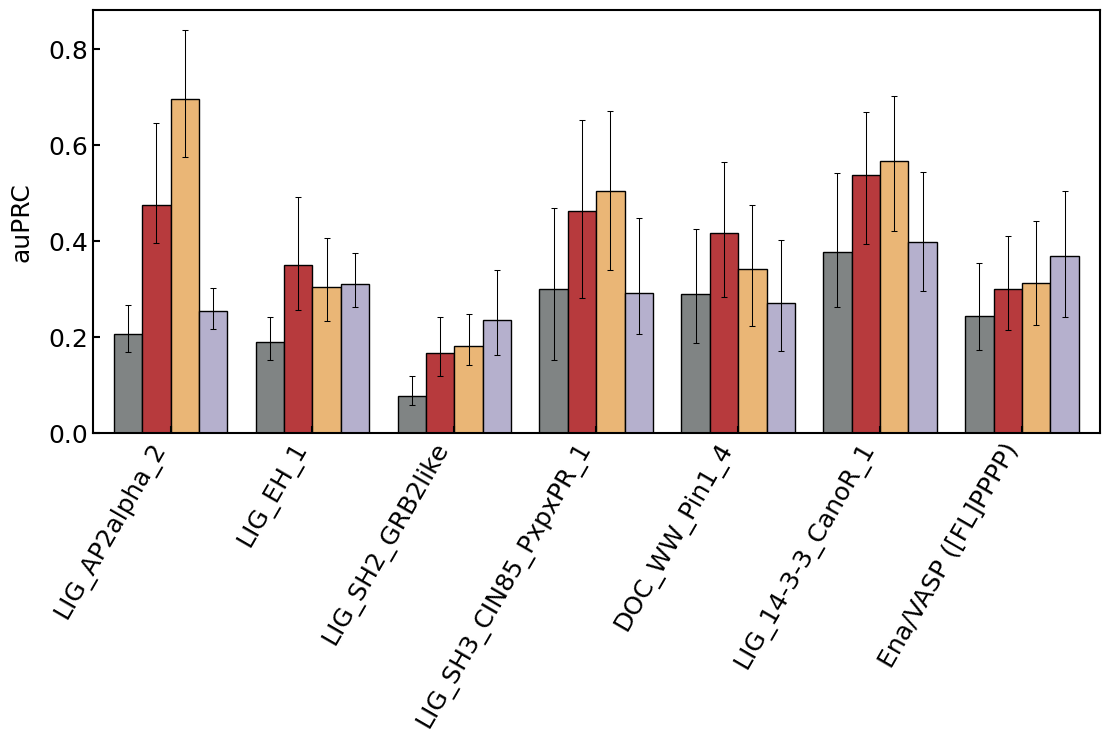

In [30]:
temp = auprc_slim_df.copy()
temp = temp[
    (temp["level"] == "Metazoa")
].copy()
temp = temp[temp["rflank"] != "5.0"]
fig, ax = plt.subplots(figsize=(13, 5.5))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = temp["ELM_motif_class"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 0.75, "capthick": 0.75, "capsize": 2},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0.25, len(labels) - 0.15)
plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)